In [1]:
from langchain_ollama import ChatOllama
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage

In [3]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Literal
from pydantic import BaseModel , Field
from dotenv import load_dotenv

In [4]:
from langchain_community.tools import StructuredTool
from pydantic import BaseModel, Field

In [5]:
from langchain.agents import create_agent

In [6]:
from typing import List

In [7]:
model = ChatOllama(model="mistral")

In [27]:
class dataBMI(BaseModel):
    height : float = Field(description ="height of the person" )
    weight : float = Field(description ="weight of the person ")


def getBMI(height : float, weight : float)-> float:
     return weight/((height/100)**2)


bmi_tool =  StructuredTool.from_function(
    func=getBMI,
    name = "bmi_tool",
    description="It calculates the bmi of the person given height and weight.",
    args_schema = dataBMI
)

In [9]:
sys_prompt = SystemMessage(content = """
Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}
""")

In [28]:
agent = create_agent(
    model=model,
    tools=[bmi_tool],
    system_prompt=sys_prompt
)

In [11]:
class bmiSchema(BaseModel):
    bmi_value : float = Field(description="The value of BMI")
    bmi_status: Literal['Good',"Bad"] = Field(description="This indicate the status of the BMI whether is it good or bad.")

In [12]:
structured_model = model.with_structured_output(bmiSchema)

In [13]:
class adviceSchema(BaseModel):
    severity : Literal['low',"Medium","high","very high"]  = Field(description="Describe severity of BMI")
    plan : List[str] = Field(description="This is list of action which need to be taken to reduce BMI")

In [14]:
structured_model_advice  = model.with_structured_output(adviceSchema)

In [15]:
class bmi_state(TypedDict):
    query : str
    bmi_value : float
    bmi_status : Literal['Good',"Bad"]
    neg_response : dict
    pos_response : str 

In [16]:
def find_bmi(state : bmi_state):
    prompt = state['query']
    result = agent.invoke(
    {"messages": [HumanMessage(content=prompt)]}
)
    result = structured_model.invoke(result.get("messages")[1].content)
    bmi_value = result.bmi_value
    bmi_status = result.bmi_status
    
    return {"bmi_value":bmi_value , "bmi_status":bmi_status}

In [17]:
def check_bmi(state : bmi_state) -> Literal["positive_response","negative_response"] :
    if state["bmi_status"] == "Good":
        return "positive_response"
    else:
        return "negative_response"

In [18]:
def positive_response(state: bmi_state):

    prompt = f"Based on BMI value {state['bmi_value']} say something positive in one sentence."
    response = model.invoke(prompt).content

    return {"pos_response":response}

def negative_response(state: bmi_state):

    prompt =  f"Base on the BMI value {state['bmi_value']} prvide structured output severity [low, medium , high ,very high] and advice in 4 points."

    response = structured_model_advice.invoke(prompt)
    return {"neg_response":response.model_dump()} 
    

In [19]:
builder = StateGraph(bmi_state)
builder.add_node("find_bmi",find_bmi)
builder.add_node("positive_response",positive_response)
builder.add_node("negative_response",negative_response)
builder.add_edge(START,"find_bmi")
builder.add_conditional_edges("find_bmi",check_bmi)
# builder.add_edge("find_bmi","check_bmi")


builder.add_edge("positive_response",END)
builder.add_edge("negative_response",END)

graph = builder.compile()

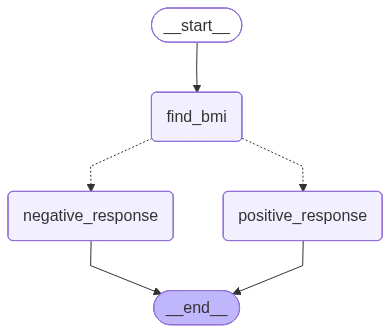

In [20]:
graph

In [ ]:
initial_state = {
    "query": "What is the BMI of the person if his height is 187 and weight 155 ?"
}

graph.invoke(initial_state)

{'query': 'What is the BMI of the person if his height is 187 and weight 155 ?',
 'bmi_value': 23.68,
 'bmi_status': 'Bad',
 'neg_response': {'severity': 'Medium',
  'plan': ["Your Body Mass Index (BMI) is 23.68, which falls within the 'Overweight' category according to WHO standards. However, it's slightly below the borderline of 'Obese'. This suggests a moderate risk for health problems in the future.",
   'I recommend maintaining your current weight or aiming to lose a modest amount (around 5-10% of your current weight) to reduce this risk. Consult with a healthcare professional to discuss a safe and effective weight loss plan tailored to your needs.',
   'Regular exercise is crucial for overall health and can help manage weight. Aim for at least 150 minutes of moderate aerobic activity or 75 minutes of vigorous activity per week, along with muscle-strengthening activities on two or more days a week.',
   'A balanced diet rich in fruits, vegetables, lean proteins, and whole grains i